# Creating Prediction Model

We will be creating multiple linear regression models that will try and predict housing prices based on the features in our cleaned datasets. The models will be evaluated based on the root mean squared error (RMSE) of their predictions against the validation set. Once the best production model is found, the final model will then be retrained using the entire training dataset then its test set predictions will be submitted to Kaggle to determine the actual test score.

## Contents:
- [Finding Production Model](#Finding-Production-Model)
- [Submission](#Submission)
- [Conclusions](#Conclusions)

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.feature_selection import RFE
import sklearn.metrics as metrics

%matplotlib inline

## Null Regression

First, we will be creating a null regression model using the train target mean as the predicted value. This is the most basic form of prediction we can perform and will serve as the baseline for our model evaluation, i.e. any model we create **must** beat this score.

In [2]:
test = pd.read_csv('../datasets/test.csv')
full_train = pd.read_csv('../datasets/full_train.csv')

In [3]:
# Creating dataframe with null regression predictions
null_regression = pd.DataFrame({
    'Id': [],
    'SalePrice': []
})

null_regression['Id'] = test['Id']
null_regression['SalePrice'] = full_train['SalePrice'].mean()

In [4]:
# Exporting .csv file for submission to Kaggle
null_regression.to_csv('../datasets/null_regression_submission.csv', index=False)

Submitting the null regression predictions to Kaggle,

![null_regression_score](../images/null_regression_score.png "Null Regression Score")

## Model Preparation

First, we will separate the features matrix `X` from our target vector `y` in the cleaned datasets.

In [5]:
# Import cleaned datasets
X_test = pd.read_csv('../datasets/test_cleaned.csv')
train = pd.read_csv('../datasets/partial_train_cleaned.csv')
val = pd.read_csv('../datasets/validation_cleaned.csv')
full_train = pd.read_csv('../datasets/full_train_cleaned.csv')

In [6]:
X_train = train.drop(columns='saleprice')
X_val = val.drop(columns='saleprice')
y_train = train['saleprice']
y_val = val['saleprice']
X_full_train = full_train.drop(columns='saleprice')
y_full_train = full_train['saleprice']

For this dataset, we will be testing 3 different types of models:
1. Linear Regression with no penalty
2. Ridge Regression (l2 penalty)
3. Lasso Regression (l1 penalty)

## Full Feature Models

First, we will try creating models using all 187 features in our dataset.

### Linear Regression

In [7]:
# Instantiate
lr_full = LinearRegression()

In [8]:
# Cross validation
np.abs(cross_val_score(lr_full, X_train, y_train, scoring='neg_root_mean_squared_error').mean())

1878081818178606.8

In [9]:
# Evaluation against validation set
lr_full.fit(X_train, y_train)

np.sqrt(metrics.mean_squared_error(y_val, lr_full.predict(X_val)))

23643.348347428688

### Ridge Regression

In [10]:
# Finding best alpha term
r_alphas = np.logspace(0, 5, 200)
ridge_cv_full = RidgeCV(alphas=r_alphas, store_cv_values=True)
ridge_cv_full.fit(X_train, y_train);

In [11]:
# Best alpha
ridge_cv_full.alpha_

7.149428986597579

In [12]:
# Instantiate
ridge_full = Ridge(alpha=ridge_cv_full.alpha_)

In [13]:
# Cross validation
np.abs(cross_val_score(ridge_full, X_train, y_train, scoring='neg_root_mean_squared_error').mean())

22723.979795521573

In [14]:
# Evaluation against validation set
ridge_full.fit(X_train, y_train)

np.sqrt(metrics.mean_squared_error(y_val, ridge_full.predict(X_val)))

23355.282498223612

### Lasso Regression

In [15]:
# Finding best alpha term
lasso_cv_full = LassoCV(n_alphas=100)
lasso_cv_full.fit(X_train, y_train);

In [16]:
# Best alpha
lasso_cv_full.alpha_

64.27170023817074

In [17]:
# Instantiate
lasso_full = Lasso(alpha=lasso_cv_full.alpha_)

In [18]:
# Cross validation
np.abs(cross_val_score(lasso_full, X_train, y_train, scoring='neg_root_mean_squared_error').mean())

22777.919822137075

In [19]:
# Evaluation against validation set
lasso_full.fit(X_train, y_train)

np.sqrt(metrics.mean_squared_error(y_val, lasso_full.predict(X_val)))

23177.912524904383

| Model      | No. of Features Input | Cross Val Score | Validation Score (RMSE) |
|------------|---------------------|-----------------|-------------------|
| null regression       | -                   | -               | 83689.75 (Kaggle) |
| lr_full    | 187                 |     1.88E+15     |     23643.35     |
| ridge_full | 187                 |     22723.98    |     23355.28      |
| lasso_full | 187                 |     22777.92    |     23177.91     |



# Finding Production Model

As seen above, the models surprisingly performed quite well even though all the features were included. The basic linear regression model, however, requires further study. The RMSE score against the validation set was pretty decent, but the model had a huge cross val score. Upon further inspection, we get the RMSE scores for the individual cross validation set below:

| Cross Validation Set | 1        | 2        | 3        | 4        | 5        |
|----------------------|----------|----------|----------|----------|----------|
| RMSE                 | 6.11E+13 | 5.98E+15 | 2.13E+04 | 3.25E+15 | 9.43E+13 |

From this, we notice that set 3 had a pretty good RMSE score. However, the average score was greatly affected by the other 4 sets that had much larger RMSE scores, in orders of several magnitudes. When considering the decent validation score alongside this information, we can surmise that the presence of outliers in certain folds of the training set greatly influenced the resulting RMSE scores, and that the validation fold in set 3 as well as the validation set did not contain significant outliers, by random chance due to shuffling.

This is because the basic linear regression model does not involve any regularisation, and thus the coefficients for each feature could be very large, especially when including all available features into the model as we just did. Thus, any outlier would have a very significant effect on the RMSE score as the individual error for these outliers would be huge. This model would not be a good choice as the test set (and real life, for that matter) would probably contain outliers as well and this model would not perform well in these situations.

As for the ridge and lasso models, they actually had pretty good scores for both the cross validation and testing against the validation dataset. The main reason for this is that these regressions regularise the models and shrink the regression coefficients. Features that are deemed to be unimportant in contributing to the predictive value of the model are given smaller coefficients. Thus, the models tend to have lower variance and can generalise to new data better. In the case of lasso, it actually shrinks coefficients for irrelevant features to 0, thus further reducing the noise in the data, which could explain its better score as compared to the ridge model.

Despite the good results, however, we will not stop here. The good results from the models with all 187 features come at the expense of interpretability. Complex models, although they may perform better, are harder to understand with over 100 features included. Stakeholders such as home owners who wish to improve their house value may not find these models very intuitive or useful. Furthermore, even with regularisation, there might still be many 'noisy' features in the model that are meaningless and do not contribute to an accurate predictive value.


## Feature Selection

The best way to resolve this is to cut down on the number of features included in the model. This will help us achieve a good balance between the interpretability and predictive value of the model. We can methodically shortlist the features so that we can attain validation scores close to that of the full-featured lasso model, the best performing so far. We will explore shortlisting features using two methods, and compare their results:
1. Filtering features based on correlation with the target variable
2. Recursive Feature Elimination

### Filtering Features

Here, we take a subset of the relevant features by plotting the Pearson correlation heatmap and selecting the features with the highest correlation with the target variable. The exact number to select is up for interpretation, but we will be going with the top 35 features for now.

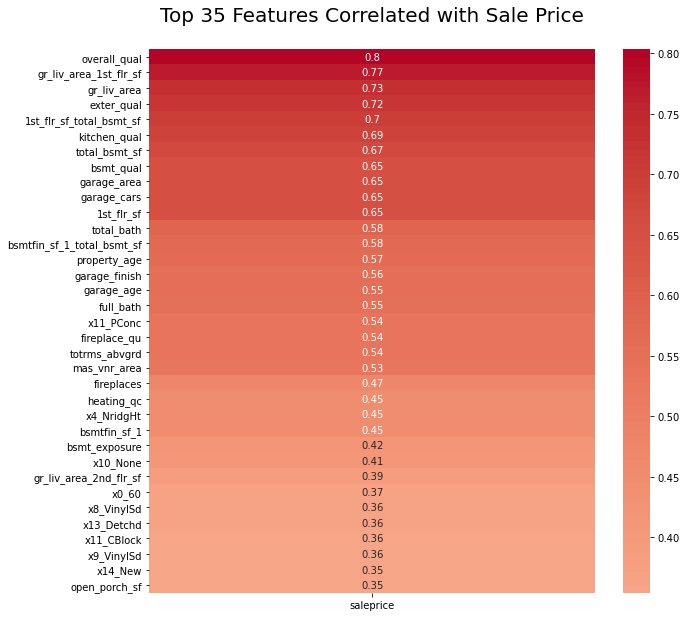

In [20]:
plt.figure(figsize=(10,10))

# Taking absolute value as the sign does not affect the feature's importance
corr_target = train.corr()[['saleprice']].abs().sort_values('saleprice',ascending=False)

sns.heatmap(
    corr_target[1:36],
    annot=True,
    cmap='coolwarm', 
    center=0
)

plt.title('Top 35 Features Correlated with Sale Price\n', fontsize=20);

In [21]:
# Creating list of top 35 correlated features
filtered_features = corr_target[1:36].index.tolist()

### Recursive Feature Elimination

Another strategy we can employ to reduce the number of features is Recursive Feature Elimination (RFE), which works by recursively removing features and rebuilding a particular model on the features that remain. It also gives each feature a ranking based on their coefficient and continues until it hits a specified target. Similar to before, we will be trying to find the top 35 features using each model.

#### Linear Regression

In [22]:
model = LinearRegression()
rfe = RFE(model, n_features_to_select=35)

# Fitting to training data
X_train_rfe = rfe.fit_transform(X_train, y_train)
model.fit(X_train_rfe, y_train)

# Tabulating RFE results
rfe_results = [np.array(X_train.columns), rfe.ranking_]
rfe_results_df = pd.DataFrame(rfe_results).T
rfe_results_df.columns = ['Feature', 'RFE Ranking']

# Top 35 features
rfe_lr_features = rfe_results_df.loc[rfe_results_df['RFE Ranking'] == 1, 'Feature'].tolist()

#### Ridge Regression

In [23]:
# Using similar alpha for ease of computation
model = Ridge(alpha=ridge_cv_full.alpha_)
rfe = RFE(model, n_features_to_select=35)

# Fitting to training data
X_train_rfe = rfe.fit_transform(X_train, y_train)
model.fit(X_train_rfe, y_train)

# Tabulating RFE results
rfe_results = [np.array(X_train.columns), rfe.ranking_]
rfe_results_df = pd.DataFrame(rfe_results).T
rfe_results_df.columns = ['Feature', 'RFE Ranking']

# Top 35 features
rfe_ridge_features = rfe_results_df.loc[rfe_results_df['RFE Ranking'] == 1, 'Feature'].tolist()

#### Lasso Regression

In [24]:
# Using similar alpha for ease of computation
model = Lasso(alpha=lasso_cv_full.alpha_, max_iter=10000)
rfe = RFE(model, n_features_to_select=35)

# Fitting to training data
X_train_rfe = rfe.fit_transform(X_train, y_train)
model.fit(X_train_rfe, y_train)

# Tabulating RFE results
rfe_results = [np.array(X_train.columns), rfe.ranking_]
rfe_results_df = pd.DataFrame(rfe_results).T
rfe_results_df.columns = ['Feature', 'RFE Ranking']

# Top 35 features
rfe_lasso_features = rfe_results_df.loc[rfe_results_df['RFE Ranking'] == 1, 'Feature'].tolist()

### Testing Features Selected

We now have 4 different sets of features from our various methods of feature elimination. We will compare their results for each of the regression models.

In [25]:
reduced_features = [filtered_features, rfe_lr_features, rfe_ridge_features, rfe_lasso_features]

In [26]:
# Linear Regression
for i, feature_list in enumerate(reduced_features):
    X_train_less = X_train[feature_list]
    lr_reduced = LinearRegression()
    cvs = np.abs(cross_val_score(lr_reduced, X_train_less, y_train, scoring='neg_root_mean_squared_error').mean())
    lr_reduced.fit(X_train_less, y_train)
    val_score = np.sqrt(metrics.mean_squared_error(y_val, lr_reduced.predict(X_val[feature_list])))
    print(i)
    print(f'CVS: {cvs}')
    print(f'Validation Score: {val_score}')
    print()

0
CVS: 25326.1614179098
Validation Score: 26650.973832359265

1
CVS: 1.4036669179752044e+16
Validation Score: 53199.93364435702

2
CVS: 24742.888962921963
Validation Score: 25374.48139461097

3
CVS: 23393.041979689002
Validation Score: 24076.009040405872



In [27]:
# Ridge Regression
for i, feature_list in enumerate(reduced_features):
    X_train_less = X_train[feature_list]
    r_alphas = np.logspace(0, 5, 200)
    ridge_cv_red = RidgeCV(alphas=r_alphas, store_cv_values=True)
    ridge_cv_red.fit(X_train_less, y_train)
    ridge_red = Ridge(alpha=ridge_cv_red.alpha_)
    cvs = np.abs(cross_val_score(ridge_red, X_train_less, y_train, scoring='neg_root_mean_squared_error').mean())
    ridge_red.fit(X_train_less, y_train)
    val_score = np.sqrt(metrics.mean_squared_error(y_val, ridge_red.predict(X_val[feature_list])))
    print(i)
    print(f'CVS: {cvs}')
    print(f'Validation Score: {val_score}')
    print()

0
CVS: 25299.6473671258
Validation Score: 26580.14202737306

1
CVS: 53558.57017408032
Validation Score: 52815.536129441825

2
CVS: 24671.25397077955
Validation Score: 25370.437057704163

3
CVS: 23361.989784300407
Validation Score: 24070.349795262533



In [28]:
# Lasso Regression
for i, feature_list in enumerate(reduced_features):
    X_train_less = X_train[feature_list]
    lasso_cv_red = LassoCV(n_alphas=100, max_iter=10000)
    lasso_cv_red.fit(X_train_less, y_train)
    lasso_red = Lasso(alpha=lasso_cv_red.alpha_, max_iter=10000)
    cvs = np.abs(cross_val_score(lasso_red, X_train_less, y_train, scoring='neg_root_mean_squared_error').mean())
    lasso_red.fit(X_train_less, y_train)
    val_score = np.sqrt(metrics.mean_squared_error(y_val, lasso_red.predict(X_val[feature_list])))
    print(i)
    print(f'CVS: {cvs}')
    print(f'Validation Score: {val_score}')
    print()

0
CVS: 25264.239062015906
Validation Score: 26540.904174183215

1
CVS: 53568.739871727536
Validation Score: 52732.22957155243

2
CVS: 24840.698781907
Validation Score: 25148.21131042284

3
CVS: 23532.409015491055
Validation Score: 23824.172210418175



| Feature List      | No. of Features | LR CVS   | LR Validation Score | Ridge CVS | Ridge Validation Score | Lasso CVS | Lasso Validation Score |
|-------------------|-----------------|----------|---------------------|-----------|------------------------|-----------|------------------------|
| Filtered Features | 35              | 25326.16 | 26650.97            | 25299.65  | 26580.14               | 25264.24  | 26540.9                |
| RFE (LR)          | 35              | 1.40E+16 | 53199.93            | 53558.57  | 52815.54               | 53568.74  | 52732.23               |
| RFE (Ridge)       | 35              | 24742.89 | 25374.48            | 24671.25  | 25370.44               | 24840.7   | 25148.21               |
| RFE (Lasso)       | 35              | 23393.04 | 24076.01            | 23361.99  | 24070.35               | 23532.41  | 23824.17               |

As seen from above, they generally performed similarly to each other, with the exception of linear regression RFE, which had much higher cross validation scores and RMSE scores against the validation set. This is likely due to similar reasons as explained earlier.

Overall, the Lasso RFE method combined with a lasso regression model produced the best results. Lasso regression actually acts as a form of feature elimination by itself as it assigns a zero coefficient to features that are unimportant. However, recursively running the lasso regression within the RFE helps us to reduce the number of features even further to a number that we are comfortable with (35 in this case). Although this method may remove some features that do have some predictive value, the resulting 35 features are enough to provide a reasonably good RMSE score (only ~600 higher than fully-featured lasso model) while still having few enough features for it to be comfortably interpretable.

### Combining RFE & Filter

We can explore combining the two methods by first reducing the number of features by filtering based on correlation to sale price, then applying RFE to select the best features.

In [29]:
# Filtering by correlation with saleprice
corr_target_comb = train.corr()[['saleprice']].abs().sort_values('saleprice',ascending=False)
filtered_features_comb = corr_target[1:76].index.tolist()

In [30]:
# Use Lasso RFE, test with different numbers of features
feature_list_dict = {}
for no_of_features in [20, 25, 30, 35]:
    X_train_comb = X_train[filtered_features_comb]
    lasso_cv_comb = LassoCV(n_alphas=100)
    lasso_cv_comb.fit(X_train_comb, y_train)
    model = Lasso(alpha=lasso_cv_comb.alpha_, max_iter=10000)
    rfe = RFE(model, n_features_to_select=no_of_features)

    # Fitting to training data
    X_train_rfe = rfe.fit_transform(X_train_comb, y_train)
    model.fit(X_train_rfe, y_train)

    # Tabulating RFE results
    rfe_results = [np.array(X_train_comb.columns), rfe.ranking_]
    rfe_results_df = pd.DataFrame(rfe_results).T
    rfe_results_df.columns = ['Feature', 'RFE Ranking']

    # Top features
    rfe_lasso_features_comb = rfe_results_df.loc[rfe_results_df['RFE Ranking'] == 1, 'Feature'].tolist()
    feature_list_dict[no_of_features] = rfe_lasso_features_comb

Testing each list of features:

In [31]:
# Linear Regression
for i, feature_list in feature_list_dict.items():
    X_train_less = X_train[feature_list]
    lr_reduced = LinearRegression()
    cvs = np.abs(cross_val_score(lr_reduced, X_train_less, y_train, scoring='neg_root_mean_squared_error').mean())
    lr_reduced.fit(X_train_less, y_train)
    val_score = np.sqrt(metrics.mean_squared_error(y_val, lr_reduced.predict(X_val[feature_list])))
    print(i)
    print(f'CVS: {cvs}')
    print(f'Validation Score: {val_score}')
    print()

20
CVS: 25399.90052695509
Validation Score: 25860.913933135645

25
CVS: 24354.12883128564
Validation Score: 25253.340598968476

30
CVS: 24276.75980262961
Validation Score: 24768.702384694403

35
CVS: 24279.126085830878
Validation Score: 24801.912345237764



In [32]:
# Ridge Regression
for i, feature_list in feature_list_dict.items():
    X_train_less = X_train[feature_list]
    r_alphas = np.logspace(0, 5, 200)
    ridge_cv_red = RidgeCV(alphas=r_alphas, store_cv_values=True)
    ridge_cv_red.fit(X_train_less, y_train)
    ridge_red = Ridge(alpha=ridge_cv_red.alpha_)
    cvs = np.abs(cross_val_score(ridge_red, X_train_less, y_train, scoring='neg_root_mean_squared_error').mean())
    ridge_red.fit(X_train_less, y_train)
    val_score = np.sqrt(metrics.mean_squared_error(y_val, ridge_red.predict(X_val[feature_list])))
    print(i)
    print(f'CVS: {cvs}')
    print(f'Validation Score: {val_score}')
    print()

20
CVS: 25311.261013557472
Validation Score: 25840.269752870623

25
CVS: 24244.55961282274
Validation Score: 25234.246845990223

30
CVS: 24108.202097616566
Validation Score: 24741.704578242057

35
CVS: 24042.932631452153
Validation Score: 24775.749338434005



In [33]:
# Lasso Regression
for i, feature_list in feature_list_dict.items():
    X_train_less = X_train[feature_list]
    lasso_cv_red = LassoCV(n_alphas=100)
    lasso_cv_red.fit(X_train_less, y_train)
    lasso_red = Lasso(alpha=lasso_cv_red.alpha_)
    cvs = np.abs(cross_val_score(lasso_red, X_train_less, y_train, scoring='neg_root_mean_squared_error').mean())
    lasso_red.fit(X_train_less, y_train)
    val_score = np.sqrt(metrics.mean_squared_error(y_val, lasso_red.predict(X_val[feature_list])))
    print(i)
    print(f'CVS: {cvs}')
    print(f'Validation Score: {val_score}')
    print()

20
CVS: 25377.728848464634
Validation Score: 25865.727013430995

25
CVS: 24329.966359338578
Validation Score: 25193.037547250442

30
CVS: 24226.32782915899
Validation Score: 24736.72890151967

35
CVS: 24207.068964076734
Validation Score: 24761.15039754665



| No. of Features | LR CVS   | LR Validation Score | Ridge CVS | Ridge Validation Score | Lasso CVS | Lasso Validation Score 
|-----------------|----------|---------------------|-----------|------------------------|-----------|------------------------|
| 20              | 25399.9  | 25860.91            | 25311.26  | 25840.27               | 25377.73  | 25865.73                              |
| 25              | 24354.13 | 25253.34            | 24244.56  | 25234.25               | 24329.97  | 25193.04                            |
| 30              | 24276.76 | 24768.7             | 24108.2   | 24741.7                | 24226.33  | 24736.73                            |
| 35              | 24279.13 | 24801.91            | 24042.93  | 24775.75               | 24207.07  | 24761.15                            |

Based on the comparison, the ideal number of features seemed to be 30. However, the models with the features obtained by a combination of both methods did not yield results as good as those that were obtained through pure RFE like before. A reason for this could be that the filtering via correlation coefficient method could have actually resulted in several collinear features, which would not contribute as much to the predictive value of the final model.

### Final Model

Based on the above, we will select 30 features using the lasso RFE method and create a lasso regression model based on these features.

In [34]:
# Finding best alpha from initial lasso RFE feature list for ease of computation
lasso_cv_rfe = LassoCV(n_alphas=100)
lasso_cv_rfe.fit(X_train[rfe_lasso_features], y_train);

In [35]:
model = Lasso(alpha=lasso_cv_rfe.alpha_, max_iter=10000)
rfe = RFE(model, n_features_to_select=30)

# Fitting to training data
X_train_rfe = rfe.fit_transform(X_train, y_train)
model.fit(X_train_rfe, y_train)

# Tabulating RFE results
rfe_results = [np.array(X_train.columns), rfe.ranking_]
rfe_results_df = pd.DataFrame(rfe_results).T
rfe_results_df.columns = ['Feature', 'RFE Ranking']

# Top 30 features
final_feature_list = rfe_results_df.loc[rfe_results_df['RFE Ranking'] == 1, 'Feature'].tolist()

In [36]:
final_feature_list

['x0_60',
 'x2_HLS',
 'x4_BrkSide',
 'x4_Crawfor',
 'x4_GrnHill',
 'x4_NoRidge',
 'x4_NridgHt',
 'x4_Somerst',
 'x4_StoneBr',
 'x5_1Fam',
 'x5_Twnhs',
 'x7_Mansard',
 'x8_BrkFace',
 'x9_CmentBd',
 'x10_BrkCmn',
 'x10_None',
 'x10_Stone',
 'x14_New',
 'overall_qual',
 'overall_cond',
 'exter_qual',
 'kitchen_qual',
 'lot_area',
 'mas_vnr_area',
 '2nd_flr_sf',
 'property_age',
 '1st_flr_sf_total_bsmt_sf',
 'bsmtfin_sf_1_total_bsmt_sf',
 'gr_liv_area_2nd_flr_sf',
 'gr_liv_area_1st_flr_sf']

# Submission


Kaggle expects submissions in a specific format. We will re-train the model on the entire training dataset (including the validation set) in order for the model to have more information and perform better, then format the submission file.

In [37]:
# Retrain model on entire training dataset
X_final = X_full_train[final_feature_list]

# Finding best alpha
lasso_cv_final = LassoCV(n_alphas=100)
lasso_cv_final.fit(X_final, y_full_train)

# Creating final model
model_final = Lasso(alpha=lasso_cv_final.alpha_)
model_final.fit(X_final, y_full_train)

# Creating predictions on test set
test_preds = model_final.predict(X_test[final_feature_list])

In [38]:
# Creating dataframe with final predicted values
final_sub = pd.DataFrame({
    'Id': [],
    'SalePrice': []
})

final_sub['Id'] = test['Id']
final_sub['SalePrice'] = test_preds

In [39]:
# Checking format & no. of rows
final_sub

,Id,SalePrice
0,2658,135217.551184
1,2718,160853.928397
2,2414,220704.310231
3,1989,111511.905981
4,625,164362.445099
...,...,...
874,1662,194043.805539
875,1234,228143.349962
876,1373,125421.574564
877,1672,114817.004475


In [40]:
# Export for submission
final_sub.to_csv('../datasets/final_submission.csv', index=False)

![final_rmse_score](../images/final_rmse_22661.png "Final RMSE")

# Conclusions

Our model returned a pretty decent RMSE score of about 22,600. As compared to the null regression (83689), it shows that our model would quite a fair bit of value to home-owners who would want to predict the sale price of their homes. This resolves our problem statement, **How can we best predict the sale price of a house using a linear regression model?**

## Interpreting Coefficients

Feature coefficients can be simply interpreted as `Bx` in the linear regression equation: `Y = B0 + B1X1 + ... + BxXx + e`

`B0` represents the intercept while `Bx` represents the slope parameter. For instance,

In [53]:
final_feature_list[18]

'overall_qual'

In [54]:
model_final.coef_[18]

16573.341563087917

In [44]:
model_final.intercept_

159106.48091493032

Suggests that `overall_qual` impact on our model is as follows:
`sale_price` = 159106.48 + 16573.34(`overall_qual`)

Meaning to say, a one unit increase in overall quality of the house would relate to a predicted increase in sale price of $16,573.34.

## Recommendations

We can interpret the model further by finding features that appear to add the most value to a home, which would be useful information to home owners.

In [45]:
coefs = pd.DataFrame([final_feature_list, model_final.coef_]).T

In [46]:
coefs.columns = ['feature', 'Coefficient']

In [47]:
coefs.sort_values(by='Coefficient', ascending=False).head(8)

,feature,Coefficient
8,x4_StoneBr,35529.8
6,x4_NridgHt,30779.7
4,x4_GrnHill,26015.6
28,gr_liv_area_2nd_flr_sf,19900.5
17,x14_New,18067.5
18,overall_qual,16573.3
3,x4_Crawfor,14894.3
27,bsmtfin_sf_1_total_bsmt_sf,14500.7


The features with the highest coefficients include physical neighbourhood locations (`StoneBr`, `NrigHt` and `GrnHill`), which suggests that these are exclusive neighbourhoods with high property values. There are also 2 interaction features relating to the size of the house, which explains that the bigger the house, the higher its value. The `overall_qual` of the house is also an important factor in increasing the sale price of the house.

In [48]:
coefs.sort_values(by='Coefficient', ascending=True).head(8)

,feature,Coefficient
11,x7_Mansard,-16822.4
25,property_age,-11810.4
14,x10_BrkCmn,-9386.58
10,x5_Twnhs,-5185.86
24,2nd_flr_sf,-4804.13
13,x9_CmentBd,3604.61
15,x10_None,3815.09
0,x0_60,4833.87


Conversely, features like an aging house, a Mansard style roof and a cement boarded exterior could lead to a lower sale price.

One interesting thing to note is that the `2nd_flr_sf` feature actually had a negative effect on price *in this model*. On first glance, this does not really make sense as intuitively, a larger house area would usually mean a greater selling price. Furthermore, the other size-related features generally had a large positive effect on sale price. On further inspection, however, we find that the interaction feature `gr_liv_area_2nd_flr_sf` based off this feature actually had a larger positive effect on sale price, and so this is how the model interpreted their overall relationships to sale price.

This leads back to the tradeoff between interpretability and model performance. Besides the selection of the actual model itself, the feature engineering and preprocessing actually plays a part in this as well. Polynomial and interaction features may improve the model's performance. However, as shown above, this comes at a cost of some interpretability. 

A good way to frame our decisions throughout this model creation process is to think of the stakeholders involved - if the model was targeted towards homeowners who wanted to find out what they should improve to increase the sale price of their homes, then we should lean towards interpretability so that the model coefficients are clear and understandable to them. Conversely, if it was targeted towards real estate developers or investors whose sole aim is to have a model with the best performance, then we can lean the other way and include more polynomial & interaction features, choosing the model that results in the lowest validation RMSE score even if it involves hundreds of features.